In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn import ensemble, neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train_V2.csv')

In [3]:
# Check the shape of data. 
train.shape

(4446966, 29)

In [4]:
# Check to see what type of data I got.
train.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

# What Each Column Means

- groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- DBNOs - Number of enemy players knocked.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- kills - Number of enemy players killed.
- killStreaks - Max number of enemy players killed in a short amount of time.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- numGroups - Number of groups we have data for in the match.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


# Data Cleaning 

In [6]:
# Take an inital look at the data.
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
# Drop any null values that might be present.
pubg = train.dropna()

In [12]:
# Check to see that there is only one missing value.
pubg.shape

(4446965, 29)

In [13]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}."
      .format(pubg['kills'].mean(),pubg['kills'].quantile(0.99), pubg['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


This shows that on average most people will get one kill and then die too while there was a player who killed the majority of the competitors in the game, but we don't know if that person had won or not. Let's take a look.

In [27]:
# Create a temporary dataframe and index based on kills.
pubg_max = pubg.set_index('kills')

# Check to see it worked correctly.
pubg_max.head(25)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
kills,,,,,,,,,,,,,,,,,,,,,
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
0,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
0,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
0,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
1,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875
1,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,...,0,0.0000,0,0.00,0,0,34.70,1,0,0.0370
0,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,...,0,0.0000,0,0.00,0,0,13.50,1,1497,0.0000
0,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,2004.0000,0,0.00,0,0,1089.00,6,1500,0.7368
0,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,...,0,0.0000,0,0.00,0,0,799.90,4,0,0.3704


In [24]:
# Let's see the result
pubg_max.loc[72]

Id                 06308c988bf0c2
groupId            4c4ee1e9eb8b5e
matchId            6680c7c3d17d48
assists                         7
boosts                          4
damageDealt                  5990
DBNOs                           0
headshotKills                  64
heals                          10
killPlace                       1
killPoints                      0
killStreaks                     7
longestKill                 78.23
matchDuration                1800
matchType            normal-squad
maxPlace                       15
numGroups                      15
rankPoints                   1500
revives                         0
rideDistance                    0
roadKills                       0
swimDistance                    0
teamKills                       0
vehicleDestroys                 0
walkDistance                728.1
weaponsAcquired                35
winPoints                       0
winPlacePerc                    1
Name: 72, dtype: object

It looks like the system predicted that this player would win and it seemed like he won based on max place.

# Data Exploration 

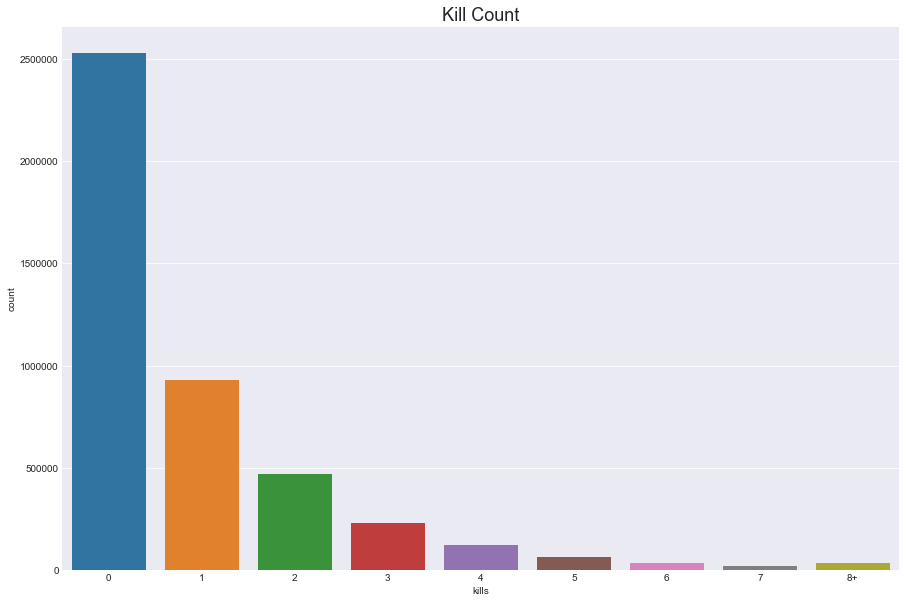

In [5]:
# Create a copy of the cleaned data set in order to easier manipulate graphs.
data = pubg.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=18)
plt.show()

Here we see that the majority of players fail to make a kill which is reasonable due to the fact that there seeems to be a barrier to entry in being a skilled player. Let see if those that make no kills have the ability to at least do some damage. 

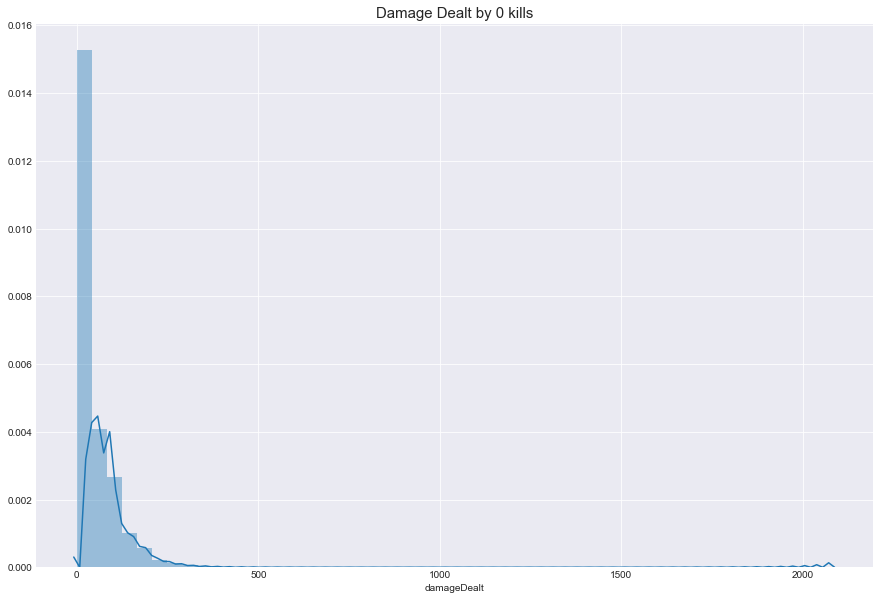

In [9]:
# Make a copy of the original data set again.
data = pubg.copy()

# Keep the naming mechanism logical
data2 = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 kills",fontsize=15)
sns.distplot(data2['damageDealt'])
plt.show()

Next lets see if kills and dealing damage have an important relationship with victory.

In [13]:
print("{} players ({:.4f}%) have won without a single kill.".format
      (len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(pubg)))

data3 = pubg[pubg['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage.".format
      (len(data3[data3['winPlacePerc']==1]), 100*len(data3[data3['winPlacePerc']==1])/len(pubg)))

127573 players (2.8688%) have won without a single kill.
4770 players (0.1073%) have won without dealing damage.


Here we can see that there is a surface level relationship where dealing damage and obtaining kills is imperative to achieving victory although exceptions also exist. 

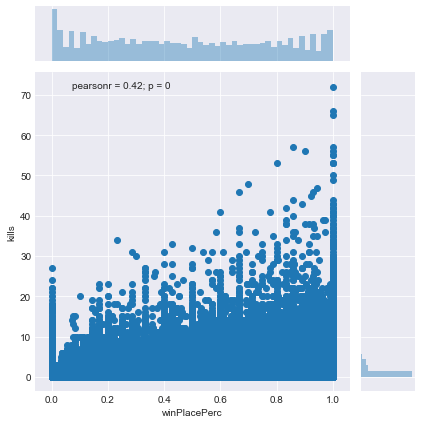

<Figure size 1440x1440 with 0 Axes>

In [17]:
# Plot win placement percentage along with kills
sns.jointplot(x="winPlacePerc", y="kills", data=pubg)
plt.figure(figsize=(20,20))
plt.show()

There is a 42% positive correlation between kills and win placement percentage. That's not too bad. 